# Отток клиентов телеком-компании

**Цель проекта:**

* Проанализировать исторические данные о клиентах, информацию об их тарифах и договорах. Спрогнозировать уход клиента из компании.
* Построить модель классификации, метрика качества AUC-ROC (минимальное значение 0.88)

**План выполнения работы:**

1. Загрузка и изучение общей информации о данных
2. Исследовательский анализ данных
    * 2.1 Исследование распределения признаков и их влияния на целевой признак
    * 2.2 Исследование корреляции признаков
3. Обучение моделей
    * 3.1 Логистическая регрессия
    * 3.3 LightGBM
    * 3.4 Catboost
4. Тестирование модели
5. Общий вывод

**Исходные данные:**

Исторические данные о клиентах, информация об их тарифах и договорах. Оператор предоставляет следующие услуги: 

1. Стационарную телефонную связь: 
    * возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет: 
    * подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).
3. Интернет-безопасность: 
    * антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
4. Выделенная линия технической поддержки (*TechSupport*);
5. Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
6. Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

*За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.*

**Описание данных:**

1. Таблица **contract** — информация о договоре;
    * `BeginDate` – дата начала пользования услугами,
    * `EndDate` – дата окончания пользования услугами,
    * `Type` – тип договора: ежемесячный, годовой и т.д,
    * `PaperlessBilling` – факт выставления счёта на электронную почту,
    * `PaymentMethod` – способ оплаты,
    * `MonthlyCharges` – ежемесячные траты на услуги,
    * `TotalCharges` – всего потрачено денег на услуги.


2. Таблица **personal** — персональные данные клиента:
    * `gender` - пол клиента,
    * `Senior Citizen` – наличие пенсионного статуса по возрасту,
    * `Partner` – наличие супруга(и),
    * `Dependents` – наличие иждивенцев.


3. Таблица **internet** — информация об интернет-услугах:
    * `InternetService` – интернет-провайдер клиента (DSL, Fiber optic),
    * `OnlineSecurity` – подключена ли услуга онлайн-безопасности,
    * `OnlineBackup` – подключена ли услуга online backup,
    * `DeviceProtection` – есть ли у клиента страховка оборудования,
    * `TechSupport` – подключена ли услуга технической поддержки,
    * `StreamingTV` – подключена ли услуга стримингового телевидения,
    * `StreamingMovies` – подключена ли услуга стримингового кинотеатра.


4. Таблица **phone** — информация об услугах телефонии:
    * `MultipleLines` – наличие возможности ведения параллельных линий во время звонка.

## 1. Загрузка и изучение общей информации о данных

In [43]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import optuna

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from imblearn.combine import SMOTETomek

SEED = 190922

In [2]:
# открываем файлы с данными
try:
    contract = pd.read_csv('final_provider\\contract.csv')
    personal = pd.read_csv('final_provider\\personal.csv')
    internet = pd.read_csv('final_provider\\internet.csv')
    phone = pd.read_csv('final_provider\\phone.csv')

except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def show_info(data):
    display(data.head(10))
    data.info()
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    display(data.describe(include=[object]))

In [4]:
show_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
Количество дубликатов: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,5,3,2,4,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5174,3875,4171,2365,11


* Таблица содержит информацию договорах клиентов, имеет 7043 записи.
* Пропусков нет.
* Дубликатов нет.
* Целевой признак (уход клиента из банка) находится в признаке `'EndDate'` - если стоит дата, значит клиент ушёл. Нам следует сделать этот признак бинарным.
* Колонки `'BeginDate'` и `'EndDate'` являются датой, их следует привести к типу datetime. Предварительно заменим значение 'No' в колонке `'EndDate'` на дату выгрузки датасета.
* Колонка `'TotalCharges'` содержит информацию о расходах клиента, тип данных необходимо привести к float.
* Бинарный признак `'PaperlessBilling'` содержит только 2 уникальных значения, ошибок нет.

In [5]:
# выводим целевой признак 'target' 1 - клиент ушел, 0 - нет
contract['target'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

# приводим к типу datetime столбец 'BeginDate'
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

# ставим дату выгрузки датасета для значений 'No' в колонке 'EndDate' и приводим к типу datetime
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'  
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S')

# приводим столбец 'TotalCharges' к типу данных float
new_type_list = []
for i in contract['TotalCharges']:
    try:
        i = float(i)
    except:
        i = 0
    new_type_list.append(i)

contract['TotalCharges'] = new_type_list

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


In [6]:
show_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Количество дубликатов: 0


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933


* Таблица содержит персональную информацию о клиентах, имеет 7043 записи.
* Пропусков нет.
* Дубликатов нет.
* Все колонки с бинарным признаком содержат только 2 уникальных значения, ошибок нет.

In [7]:
show_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Количество дубликатов: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


* Таблица содержит информацию о подключенных интернет-услугах, имеет 5517 записей.
* Пропусков нет.
* Дубликатов нет.
* Все колонки с бинарным признаком содержат только 2 уникальных значения, ошибок нет.

In [8]:
show_info(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Количество дубликатов: 0


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


* Таблица содержит информацию о подключенных услугах телефонии, имеет 6361 запись.
* Пропусков нет.
* Бинарный признак `'MultipleLines'` содержит только 2 уникальных значения, ошибок нет.

**Выводы:**
1. Данные успешно загружены, пропусков и дубликатов не обнаружено.
2. Типы данных изменены в соответствии с хранимой информацией.
3. Для дальнейшего анализа и построения модели нам потребуется объеденить данные таблиц в одну. Количество строк в таблицах с информацией об использовании услуг отличается от таблиц с данными о клиенте и его договоре. Это связано с тем, что разные клиенты пользуются разными видами услуг. При объединении таблиц у нас появятся пустые значения в итоговой таблице, такие значения стоит рассматривать как то, что клиент не пользуется данным видом услуг.

## 2. Исследовательский анализ данных

* Для начала объединим таблицы в одну по ID клиента и удалим столбец ID, так как для дальнейшего анализа он не требуется.
* Бинарные признаки приведем к виду значений 1 и 0.

In [9]:
# объединяем таблицы по колонке 'customerID'
df = (personal.merge(contract, on='customerID', how='left')
              .merge(internet, on='customerID', how='left')
              .merge(phone, on='customerID', how='left'))

# удаляем больше не нужную колонку 'customerID'
df.drop('customerID',axis=1, inplace=True)

# бинарные признаки приводим к типу 1 и 0
for feature in df.select_dtypes(include='O').columns:
    df[feature].replace(['Yes', 'No', np.nan, 'Male', 'Female'], [1, 0, 0, 1, 0], inplace=True)

df.head(10)

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0,0,1,0,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,0,0,0,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0,0,2019-03-01,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,1,Fiber optic,0.0,0.0,1.0,0.0,1.0,1.0,1.0
6,1,0,0,1,2018-04-01,2020-02-01,Month-to-month,1,Credit card (automatic),89.10,1949.40,0,Fiber optic,0.0,1.0,0.0,0.0,1.0,0.0,1.0
7,0,0,0,0,2019-04-01,2020-02-01,Month-to-month,0,Mailed check,29.75,301.90,0,DSL,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0,1,0,2017-07-01,2019-11-01,Month-to-month,1,Electronic check,104.80,3046.05,1,Fiber optic,0.0,0.0,1.0,1.0,1.0,1.0,1.0
9,1,0,0,1,2014-12-01,2020-02-01,One year,0,Bank transfer (automatic),56.15,3487.95,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0


### 2.1 Исследование распределения признаков и их влияния на целевой признак

Для начала посмотрим на распределение целевого признака.

0    0.73463
1    0.26537
Name: target, dtype: float64


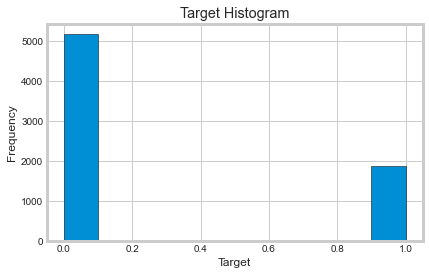

In [10]:
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")

print(df['target'].value_counts(normalize=True))
df['target'].plot.hist(title = 'Target Histogram', edgecolor = 'k', figsize = (6, 4))
plt.xlabel('Target')
plt.show()

Классы являются несбалансированными, поскольку делятся примерно в соотношении 73% и 27%. **При построении моделей следует провести балансировку.**

Посмотрим на распределение признаков с информацией о клиенте и его договоре и их влияние на таргет. Создадим функцию, которая будет показывать распределение признака и его влияние на целевой признак.

Но сначала закодируем категориальные признаки для корректного построения графиков.

In [11]:
cat_features = ['Type', 'PaymentMethod', 'InternetService']
label_dict = {}

for col in cat_features:
    label_dict[col] = {label:idx for idx, label in enumerate(set(df[col]))}
    df[col] = df[col].map(label_dict[col])

In [12]:
def show_impact_on_target(df, col, bins=10, failure_plt_s=(6, 4)):
    
    print('Распределение значений:')
    print(df[col].value_counts())
    
    # строим гистограмму распределения значений признака
    df[col].plot.hist(title = col + ' Histogram', edgecolor = 'k', bins=bins, figsize = (6, 4))
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlabel(col)
    plt.show()
    
    # строим график распределения таргета в зависимости от признака
    plt.figure(figsize = (6, 4))
    sns.kdeplot(df.loc[df['target'] == 0, col], label = 'target == 0')
    sns.kdeplot(df.loc[df['target'] == 1, col], label = 'target == 1')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title('Distribution of ' + col)
    plt.legend()
    plt.show()
    
    # строим график вероятности оттока клиентов в зависимости от признака
    plt.figure(figsize = failure_plt_s)
    plt_data = df[[col, 'target']].groupby(col).mean()
    plt_data['target'] = plt_data['target']
    plt.bar(plt_data.index.astype(str), 100 * plt_data['target'], edgecolor = 'k')
    plt.xticks(rotation= 75, fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlabel(col); 
    plt.ylabel('Churn (%)')
    plt.title('Churn by ' + col)
    plt.show()

#### Пол клиента

Распределение значений:
1    3555
0    3488
Name: gender, dtype: int64


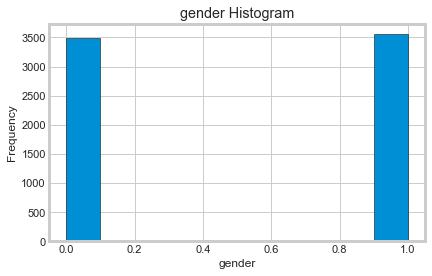

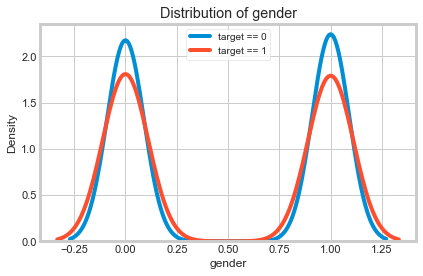

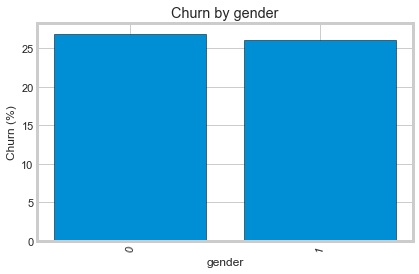

In [13]:
show_impact_on_target(df, 'gender')

* Признак сбалансирован. 
* Среди клиентов примерно одинаковое количетво мужчин и женщин.
* Зависимость ухода клиента от его пола отсутствует. **Признак можно исключить из модели.**

#### Наличие пенсионного статуса по возрасту

Распределение значений:
0    5901
1    1142
Name: SeniorCitizen, dtype: int64


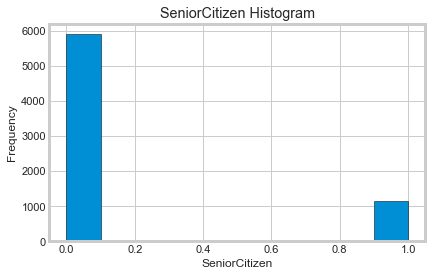

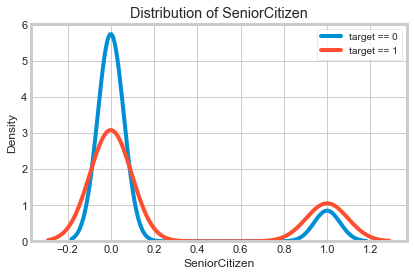

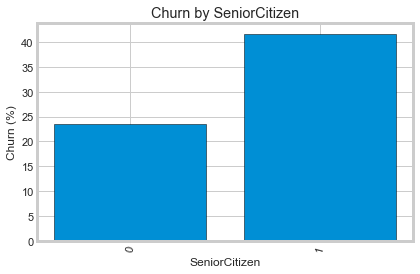

In [14]:
show_impact_on_target(df, 'SeniorCitizen')

* Признак сильно не сбалансирован. Среди клиентов преобладают люди не имеющие пенсии по возрасту.
* Мы можем наблюдать, что **пенсионеры чаще отказываются от услуг.** Возможные причины:
    * Есть операторы связи, которые предоставляют льготные условия пенсионерам и ветеранм, возможно клиенты уходят за более выгодными условиями.
    * Возможно это те пенсионеры, у которых дома жили дети или внуки, которые активно пользовались услугами компании, но съехали и клиенту стали не нужны услуги.

#### Наличие супруга(и)

Распределение значений:
0    3641
1    3402
Name: Partner, dtype: int64


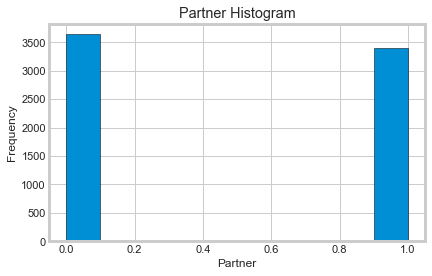

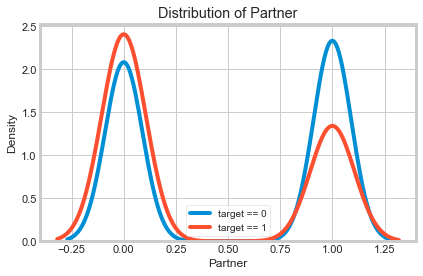

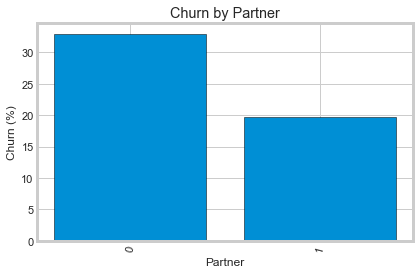

In [15]:
show_impact_on_target(df, 'Partner')

* Классы сбалансированы.
* Неженатые люди чаще отказываются от услуг **(вероятность ухода более 30%)**. Вероятнее всего это одинокие молодые люди, которые живут в съемном жилье и часто переезжают, в следствие чего и расторгают договор оказания услуг. Семейные люди менее склонны к переездам и дольше остаются в съемном жилье, либо имеют свое.

#### Наличие иждивенцев

Распределение значений:
0    4933
1    2110
Name: Dependents, dtype: int64


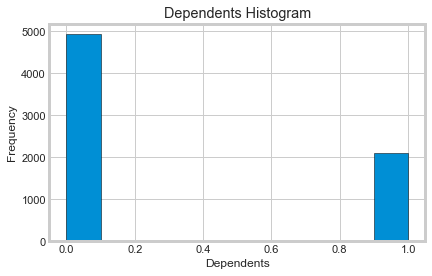

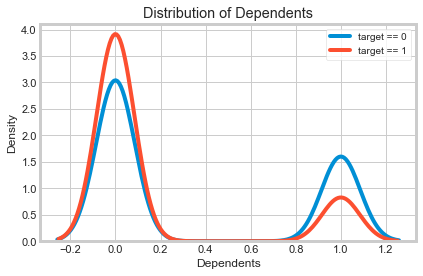

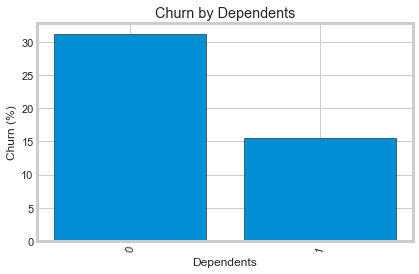

In [16]:
show_impact_on_target(df, 'Dependents')

* Классы не сбалансированы, большинство клиентов не имеют иждивенцев.
* Однако мы наблюдаем похожую ситуацию с предыдущим признаком. **При совместном проживании люди дольше остаются на обслуживании в одной компании.**

#### Тип договора

Распределение значений:
0    3875
1    1695
2    1473
Name: Type, dtype: int64


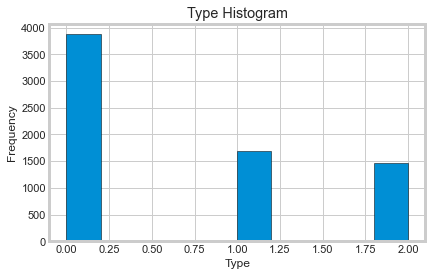

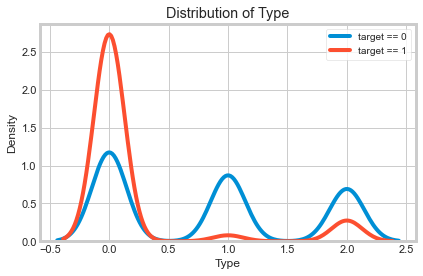

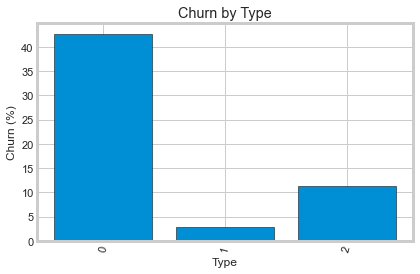

{'Month-to-month': 0, 'Two year': 1, 'One year': 2}


In [17]:
show_impact_on_target(df, 'Type')
print(label_dict['Type'])

* Большее количество клиентов имеет месячную подписку.
* Клиенты имеющие месячную подписку гораздо чаще уходят **(вероятность ухода более 40%)**, чем клиенты с годовой (10%) и двухгодовой подпиской (<5%).

#### Факт выставления счёта на электронную почту

Распределение значений:
1    4171
0    2872
Name: PaperlessBilling, dtype: int64


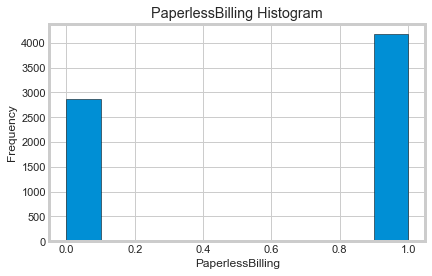

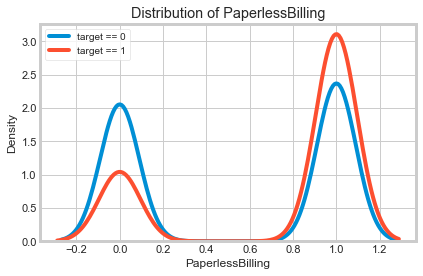

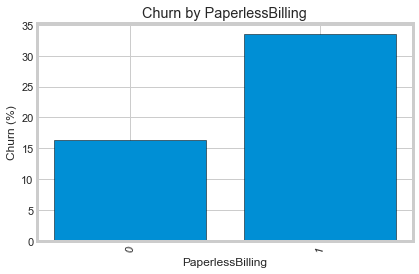

In [18]:
show_impact_on_target(df, 'PaperlessBilling')

* Большее количество клиентов (59%) получают счет по электронной почте.
* Чаще уходят клиенты, получающие счет на электронную почту (вероятность ухода 34%).

####  Способ оплаты

Распределение значений:
3    2365
2    1612
0    1544
1    1522
Name: PaymentMethod, dtype: int64


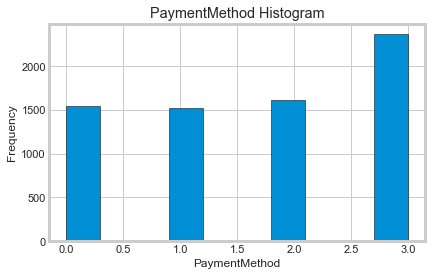

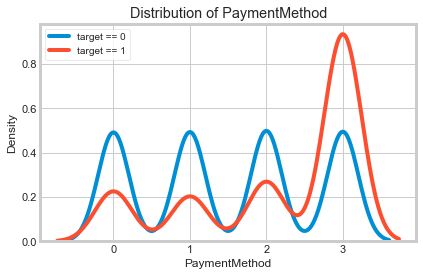

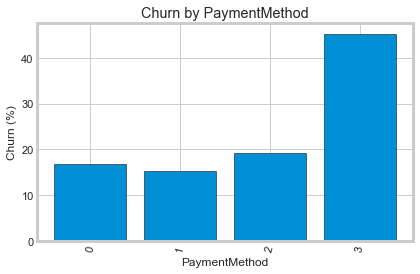

{'Bank transfer (automatic)': 0, 'Credit card (automatic)': 1, 'Mailed check': 2, 'Electronic check': 3}


In [19]:
show_impact_on_target(df, 'PaymentMethod')
print(label_dict['PaymentMethod'])

* По графикам четко прослеживается тенденция: **среди людей отправляющих электронный чек, наибольший процент оттока** (вероятность около 44%).

#### Ежемесячные траты на услуги

In [20]:
df['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

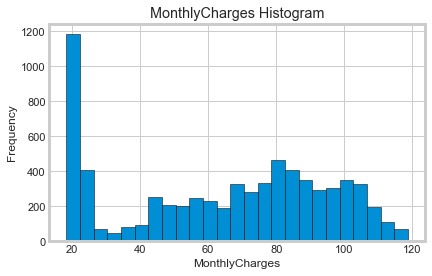

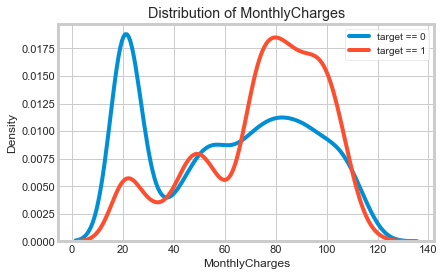

In [21]:
# строим гистограмму распределения значений признака
df['MonthlyCharges'].plot.hist(title = 'MonthlyCharges Histogram', edgecolor = 'k', bins=25, figsize = (6, 4))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('MonthlyCharges')
plt.show()

# строим график распределения таргета в зависимости от признака
plt.figure(figsize = (6, 4))
sns.kdeplot(df.loc[df['target'] == 0, 'MonthlyCharges'], label = 'target == 0')
sns.kdeplot(df.loc[df['target'] == 1, 'MonthlyCharges'], label = 'target == 1')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.title('Distribution of MonthlyCharges')
plt.legend()
plt.show()

* Средний расход в месяц составляет 64,76 у.е.
* По распределению мы можем наблюдать всплеск значений от 20 до 25 у.е. Среди этих клиентов отток минимальный.
* На графике распределения таргета в зависимости от ежемесячных расходов видим, что **отток начинается с клиентов, у которых расходы переходят границу в 65 у.е.**

#### Всего потрачено денег на услуги

In [22]:
df['TotalCharges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

In [23]:
df.loc[df['TotalCharges'] == 0]

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,0,0,1,1,2020-02-01,2020-02-01,1,1,0,52.55,0.0,0,2,1.0,0.0,1.0,1.0,1.0,0.0,0.0
753,1,0,0,1,2020-02-01,2020-02-01,1,0,2,20.25,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
936,0,0,1,1,2020-02-01,2020-02-01,1,0,2,80.85,0.0,0,2,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1082,1,0,1,1,2020-02-01,2020-02-01,1,0,2,25.75,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1340,0,0,1,1,2020-02-01,2020-02-01,1,0,1,56.05,0.0,0,2,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3331,1,0,1,1,2020-02-01,2020-02-01,1,0,2,19.85,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3826,1,0,1,1,2020-02-01,2020-02-01,1,0,2,25.35,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4380,0,0,1,1,2020-02-01,2020-02-01,1,0,2,20.00,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5218,1,0,1,1,2020-02-01,2020-02-01,2,1,2,19.70,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6670,0,0,1,1,2020-02-01,2020-02-01,1,0,2,73.35,0.0,0,2,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [24]:
df.loc[df['TotalCharges'] == 0, 'TotalCharges'] = df['MonthlyCharges']

В колонке `'TotalCharges'` имелись нулевые значения, это информация по новым клиентам, которые оформили подписку, но еще не успели сделать ни одной оплаты. Для этих строк мы заменили данные на значение из колонки `'MonthlyCharges'`, так как это расходы, которые клиент в любом случае сделает в ближайшем будущем.

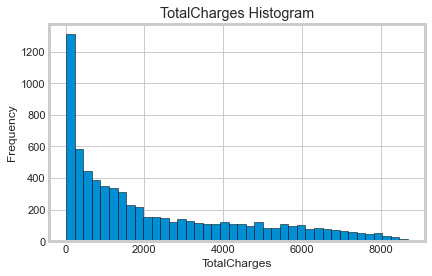

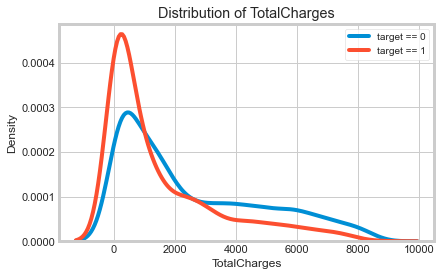

In [25]:
# строим гистограмму распределения значений признака
df['TotalCharges'].plot.hist(title = 'TotalCharges Histogram', edgecolor = 'k', bins=40, figsize = (6, 4))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('TotalCharges')
plt.show()

# строим график распределения таргета в зависимости от признака
plt.figure(figsize = (6, 4))
sns.kdeplot(df.loc[df['target'] == 0, 'TotalCharges'], label = 'target == 0')
sns.kdeplot(df.loc[df['target'] == 1, 'TotalCharges'], label = 'target == 1')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('TotalCharges')
plt.ylabel('Density')
plt.title('Distribution of TotalCharges')
plt.legend()
plt.show()

* Распределение признака имеет тяжелый правый хвост. Пик значений приходится на ~200 у.е.
* Основной отток происходит среди клиентов, потративших до ~1500 у.е.

**Выводы:**
   * Пол не влияет на уход клиента.
   * Среди пенсионеров отказ от услуг случается чаще.
   * Наличие супруга или иждевенца положительно сказывается на лояльности клиента.
   * Среди ушедших клиентов большинство имело месячную подписку, получало счет на электронную почту и оплачиваливало услуги связи электронным чеком.
   * По достижении ежемесячных трат 65 у.е. начинается отток клентов.
   * Ушедший клиент в среднем принес компании до 1500 у.е.

### 2.2 Исследование корреляции признаков

Для оценки корреляции воспользуемся коэффициентом $\phi_K$ библиотек `phik`.

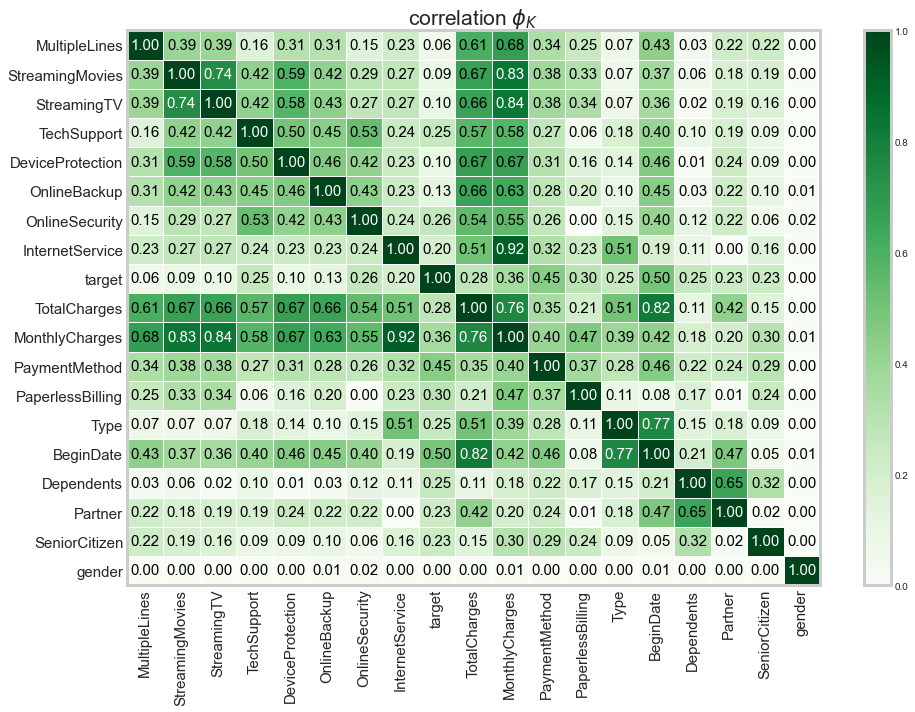

In [26]:
interval_cols = ['MonthlyCharges', 'TotalCharges']
phik_overview = df.drop('EndDate', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(14, 10))
plt.tight_layout()

По таблице корреляции через коэффициент $\phi_K$ мы видим, что:
* Для признака `'gender'` корреляция с таргетом отсутствует, **признак можно удалить.**
* Признак `'MonthlyCharges'` сильно коррелирует с признаками `'StreamingMovies'`, `'StreamingTV'`, `'InternetService`' и `'TotalCharges'`. По сути информация `'MonthlyCharges'` уже входит в признак `'TotalCharges'`, они косвенно дублируются. Во избежание мультиколинеарности **удалим его.**
* Также мы видим наличие умеренной корреляции между признаком `'BeginDate'` и таргетом. Так как использовать дату в качестве признака в чистом виде мы не можем, попробуем вывести новый признак. Посчитаем длительность договора в днях.
* Для точности проведенного анализа проверим статистическую значимость полченных коэффициентов корреляции.

In [27]:
significance_overview = df.drop('EndDate', axis=1).significance_matrix(interval_cols=interval_cols)

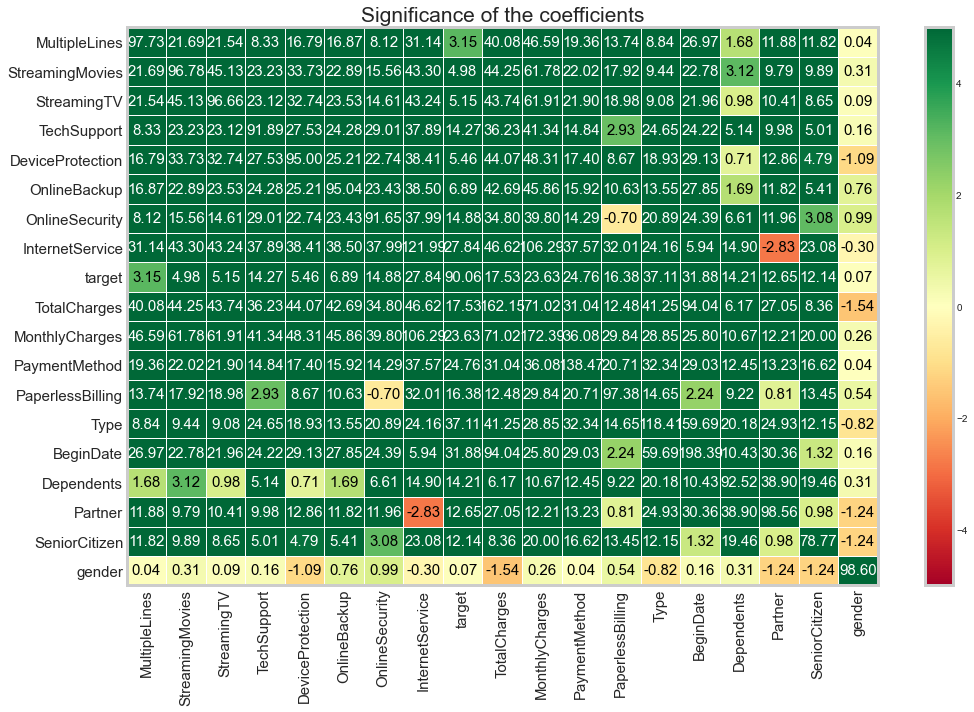

In [28]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(15, 10))
plt.tight_layout()

* Коэффициенты корреляции, на которые мы обращали внимание выше являются статистически значимыми, поэтому принимаем сделанные выводы.
* Созданим новый признак "Длительность договора в днях" и проверим корреляцию с новым признаком.

In [29]:
# выводим новый признак
df['days'] = (df['EndDate'] - df['BeginDate']).dt.days
df['days'] = df['days'].astype('int')

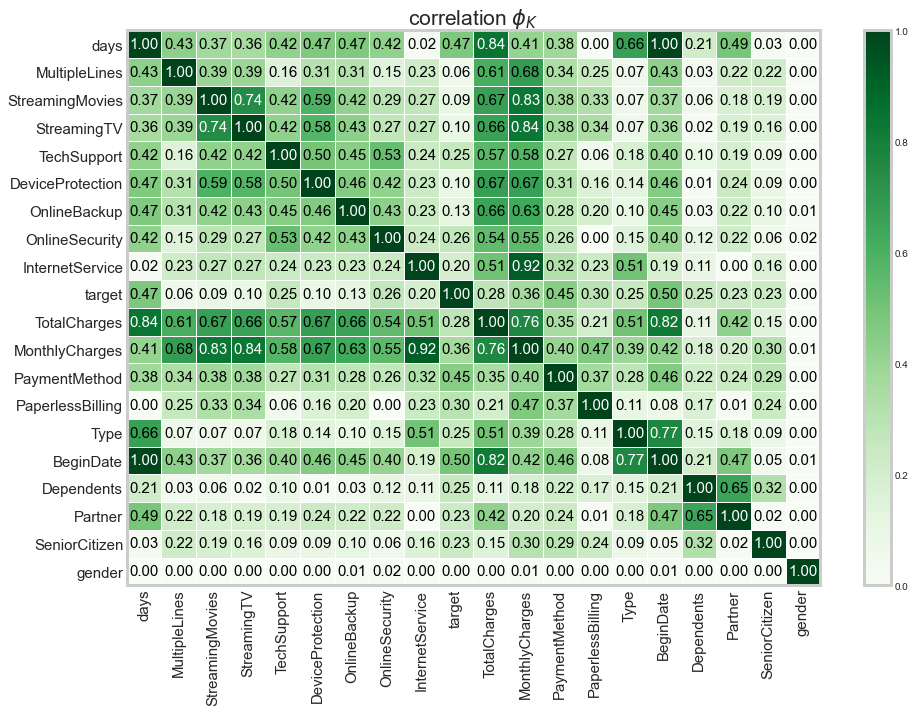

In [30]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'days']
phik_overview = df.drop('EndDate', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(14, 10))
plt.tight_layout()

* Наш новый признак имеет умеренную корреляцию с таргетом.
* Признак `'days'` сильно коррелирует с признаком `'TotalCharges'`, при этом второй имеет более слабую корреляцию с таргетом, поэтому во избежанее мультиколлинеарности следует **удалить признак `'TotalCharges'`.**
* Ранее мы планировали убрать **признак `'MonthlyCharges'`** так как он имел высокую корреляцию с признаком `'TotalCharges'`, теперь необходимости в этом нет, **оставим** его.
* Обратим внимание, что `'MonthlyCharges'` сильно коррелирует с признаками `'StreamingMovies'`, `'StreamingTV'` и `'InternetService'`, **уберем их из модели.**

In [31]:
# удаляем признаки бесполезные для модели
df.drop(['EndDate', 'BeginDate', 'gender', 'TotalCharges', 'StreamingMovies', 
         'StreamingTV', 'InternetService'], axis=1, inplace=True)

## 3. Обучение моделей

In [32]:
features = df.drop('target', axis=1)
target = df['target']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=SEED)

In [33]:
# кодируем категориальные признаки
num_features = ['MonthlyCharges', 'days']

encoder = ce.target_encoder.TargetEncoder(cols=list(X_train.drop(num_features, axis=1).columns))
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

c:\Users\Anna\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\Anna\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [34]:
# масштабируем признаки признаки

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 3.1 Логистическая регрессия

In [35]:
# инициируем модель
model_lr = LogisticRegression(max_iter=500, class_weight='balanced')

# ищем лучшие гиперпараметры для модели
param_grid = {'C': np.logspace(-3, 3, 7)}

grid_search = GridSearchCV(estimator = model_lr,
                           param_grid = param_grid, 
                           cv = 5, 
                           n_jobs = -1, 
                           scoring = 'roc_auc')
grid_search.fit(X_train, y_train)
    
# модель с лучшими параметрами кросс-валидируем по метрике roc_auc
model_lr = model_lr.set_params(**grid_search.best_params_)
score = cross_val_score(model_lr, X_train, y_train, 
                        scoring = 'roc_auc',
                        cv = 5,
                        n_jobs = -1).mean()

print(f'Параметры лучшей модели: {grid_search.best_params_}')
print(f'AUC ROC на валидации: {score}')

Параметры лучшей модели: {'C': 0.1}
AUC ROC на валидации: 0.8415141512415648


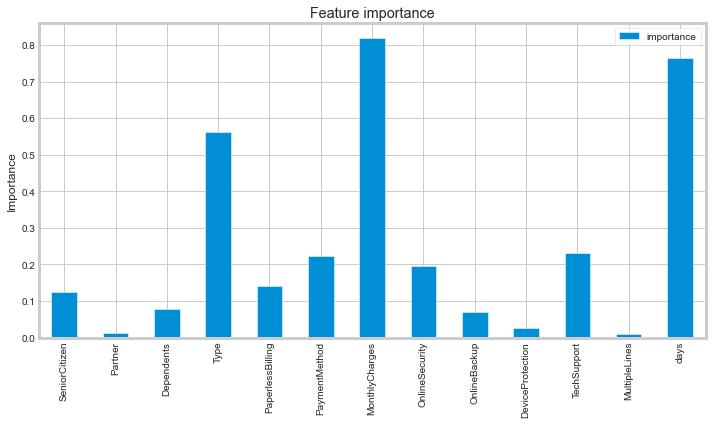

In [37]:
# строим график важности признаков для модели
model_lr.fit(X_train, y_train)
lr_imp = pd.DataFrame({'importance': abs(model_lr.coef_[0])}, 
                       index=features.columns)

fig, ax = plt.subplots(figsize=(10,6))
lr_imp.plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
fig.tight_layout()

### 3.2 Градиентный бустинг LGBM

In [38]:
%%time

# инициируем модель
model_lgbm = LGBMClassifier(objective='binary', is_unbalance=True, metric='AUC', random_state=SEED)

# ищем лучшие гиперпараметры для модели
param_grid = {
    'n_estimators': [1000],
#     'boosting_type': ['gbdt', 'dart'],
    'max_depth': range(4, 11, 2),
    'num_leaves': range(16, 30, 4),
    'min_child_samples': range(4, 8),
    'learning_rate': [0.5],
#     'reg_lambda': [1, 3, 5],
#     'reg_alpha': [1, 3, 5]
}
                                            
grid_search_lgbm = GridSearchCV(estimator = model_lgbm,
                                param_grid = param_grid, 
                                cv = 5, 
                                n_jobs = -1, 
                                scoring = 'roc_auc')
grid_search_lgbm.fit(X_train, y_train)

# модель с лучшими параметрами кросс-валидируем по метрике roc_auc
model_lgbm = model_lgbm.set_params(**grid_search_lgbm.best_params_)
score = cross_val_score(model_lgbm, X_train, y_train, 
                        scoring = 'roc_auc',
                        cv = 5,
                        n_jobs = -1).mean()

print(f'Параметры лучшей модели: {grid_search_lgbm.best_params_}')
print(f'AUC ROC на валидации: {score}')

Параметры лучшей модели: {'learning_rate': 0.5, 'max_depth': 4, 'min_child_samples': 4, 'n_estimators': 1000, 'num_leaves': 16}
AUC ROC на валидации: 0.8961379285981295
CPU times: total: 5.69 s
Wall time: 4min 6s


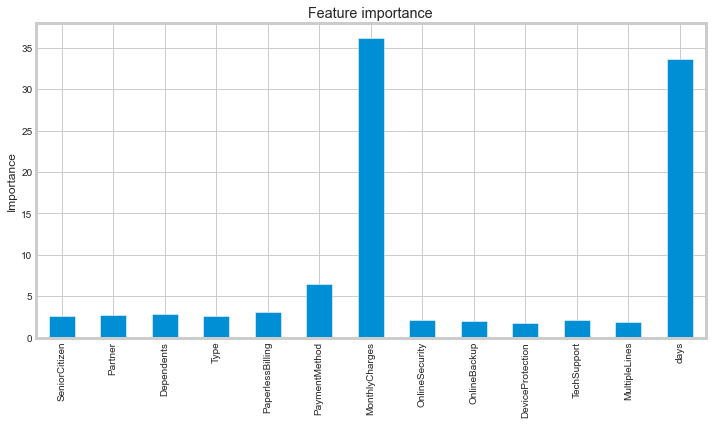

In [39]:
# строим график важности признаков для модели
model_lgbm.fit(X_train, y_train)
lgbm_imp = pd.Series(model_lgbm.feature_importances_,
                        features.columns)

lgbm_imp = lgbm_imp / lgbm_imp.sum() * 100
fig, ax = plt.subplots(figsize=(10,6))
lgbm_imp.plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
fig.tight_layout()

### 3.3 Градиентный бустинг CatBoost

In [40]:
%%time

# инициируем модель
model_cat = CatBoostClassifier(loss_function='Logloss', silent=True, random_state=SEED,
                               auto_class_weights='Balanced', eval_metric='AUC')

# ищем лучшие гиперпараметры для модели
param_grid = {
#     'iterations': [150],
#     'l2_leaf_reg': [0.1, 1, 3],
    'depth': range(2, 13, 2),  # используем только глубину, так как катбуст дает отличные результаты по умолчанию
#     'learning_rate': [0.1]
}
                                               
grid_search_cat = GridSearchCV(estimator = model_cat,
                               param_grid = param_grid, 
                               cv = 5, 
                               n_jobs = -1, 
                               scoring = 'roc_auc')
grid_search_cat.fit(X_train, y_train)

# модель с лучшими параметрами кросс-валидируем по метрике roc_auc
model_cat = model_cat.set_params(**grid_search_cat.best_params_)
score = cross_val_score(model_cat, X_train, y_train, 
                        scoring = 'roc_auc',
                        cv = 5,
                        n_jobs = -1).mean()

print(f'Параметры лучшей модели: {grid_search_cat.best_params_}')
print(f'AUC ROC на валидации: {score}')

Параметры лучшей модели: {'depth': 6}
AUC ROC на валидации: 0.8986906805760265
CPU times: total: 21.7 s
Wall time: 7min 7s


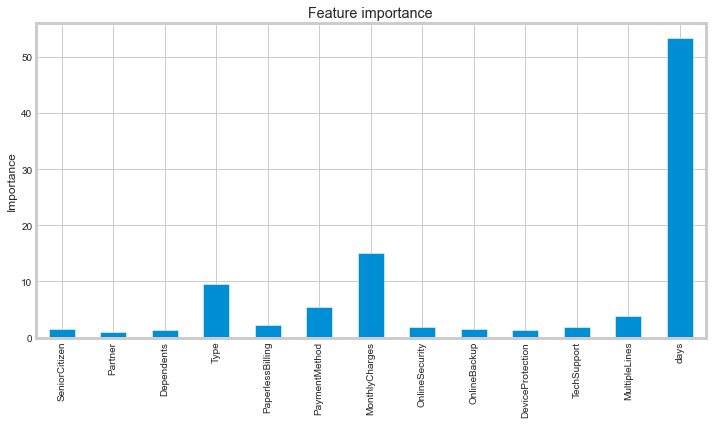

In [41]:
# строим график важности признаков для модели
model_cat.fit(X_train, y_train)
cat_imp = pd.Series(model_cat.get_feature_importance(),
                        features.columns)

fig, ax = plt.subplots(figsize=(10,6))
cat_imp.plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
fig.tight_layout()

Лучше всех показала себя модель `CatBoostClassifier`:
   * AUC ROC на валидации: 0.89869
   * Лучшие подобранные гиперпараметры:
       * depth: 6

Будем использовать эту модель в качестве основной.

## 4. Тестирование модели
Проверим оценку модели на тестовой выборке.

In [42]:
pred_cat = model_cat.predict_proba(X_test)[:, 1]
print(f'AUC ROC на тесте: {roc_auc_score(y_test, pred_cat)}')

AUC ROC на тесте: 0.8960022331569417


* Итоговая метрика AUC ROC на тесте: 0.89600, что удовлетворяет условиям ТЗ.
* Для оценки адекватности модели сравним ее со случайной величиной, используем `DummyClassifier` библиотеки `sklearn`.

In [44]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
print(f'AUC ROC на тесте: {roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])}')

AUC ROC на тесте: 0.5056628764853054


Наша модель дает оценку лучше чем dummy модель, следовательно наша модель адекватна.

## 5. Отчет

**1. Совпало ли ваше итоговое решение с планом, если нет, то почему?**

Нет. Первоначальный план включал в себя также проверку модели `RandomForest`, но в процессе работы я от нее отказалась, так как обучение и подбор параметров занимает не мало времени, а у нас есть более сильные модели-бустинги (по сути являются усиленными версиями лесов).

**2. Какие затруднения у вас были и как вы их решили?**

Были сложности с оценкой корреляции и коллинеарности для количественных и категориальных признаков, помогла тимлид с советом использовать библиотеку `phik`.

**3. Какие были ключевые шаги вашего решения?Какие признаки вошли в итоговую модель и почему? Как вы предобрабатывали эти данные?**

Ключевые шаги решения:
* 1) Загрузка и предобработка данных.
* 2) Анализ признаков и их влияний.
* 3) Исследование корреляции и коллинеарности.
* 4) Подбор моделей и их гиперпараметров с помощью `GridSearch`.

В итоговую модель вошли следующие признаки:
* `'SeniorCitizen'`, 
* `'Partner'`, 
* `'Dependents'`, 
* `'Type'`, 
* `'PaperlessBilling'`, 
* `'PaymentMethod'`, 
* `'MonthlyCharges'`, 
* `'OnlineSecurity'`, '
* `'OnlineBackup'`, 
* `'DeviceProtection'`, 
* `'TechSupport'`, 
* `'MultipleLines'`,
* `'days'` - признак, выведенный на основании имевшихся.

Признаки были отобраны на основании корелляции с целевым признаком с учетом мультиколлинеарности.

В предобработке данных потребовалось объединение таблиц в одну, так как изначально имелись разные таблицы с разными данными. Так как клиенты пользуются разными услугами, при объединении таблиц появились пропуски в столбцах с информацией о пользовании услугами. Эти данные были заполнены в соответствии со смыслом (0 - клиент не пользуется услугами). Также были нулевые значения для столбца с общими расходами для вновь прибывших клиентов. В таких данных я использовала информацию о ежемесячных расходах. Типы данных в столбцах были изменены в соответствии с их содержанием.

Лучше всех показала себя модель `CatBoostClassifier`:
   * AUC ROC на валидации: 0.89869
   * Лучшие подобранные гиперпараметры:
       * depth: 6
   * AUC ROC на тесте: 0.89600